In [1]:
import torch

def guassian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    '''
    将源域数据和目标域数据转化为核矩阵，即上文中的K
    Params: 
     source: 源域数据，行表示样本数目，列表示样本数据维度
     target: 目标域数据 同source
     kernel_mul: 多核MMD，以bandwidth为中心，两边扩展的基数，比如bandwidth/kernel_mul, bandwidth, bandwidth*kernel_mul
     kernel_num: 取不同高斯核的数量
     fix_sigma: 是否固定，如果固定，则为单核MMD
    Return:
     sum(kernel_val): 多个核矩阵之和
    '''
    n_samples = int(source.size()[0])+int(target.size()[0])
    # 求矩阵的行数，即两个域的的样本总数，一般source和target的尺度是一样的，这样便于计算
    total = torch.cat([source, target], dim=0)#将source,target按列方向合并
    #将total复制（n+m）份
    total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    #将total的每一行都复制成（n+m）行，即每个数据都扩展成（n+m）份
    total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    # total1 - total2 得到的矩阵中坐标（i,j, :）代表total中第i行数据和第j行数据之间的差 
    # sum函数，对第三维进行求和，即平方后再求和，获得高斯核指数部分的分子，是L2范数的平方
    L2_distance_square = ((total0-total1)**2).sum(2) 
    #调整高斯核函数的sigma值
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_distance_square) / (n_samples**2-n_samples)
    # 多核MMD
    #以fix_sigma为中值，以kernel_mul为倍数取kernel_num个bandwidth值（比如fix_sigma为1时，得到[0.25,0.5,1,2,4]
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
    # print(bandwidth_list)
    #高斯核函数的数学表达式
    kernel_val = [torch.exp(-L2_distance_square / bandwidth_temp) for bandwidth_temp in bandwidth_list]
    #得到最终的核矩阵
    return sum(kernel_val)#/len(kernel_val)

In [2]:
def mmd_rbf(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    '''
    计算源域数据和目标域数据的MMD距离
    Params: 
     source: 源域数据，行表示样本数目，列表示样本数据维度
     target: 目标域数据 同source
     kernel_mul: 多核MMD，以bandwidth为中心，两边扩展的基数，比如bandwidth/kernel_mul, bandwidth, bandwidth*kernel_mul
     kernel_num: 取不同高斯核的数量
     fix_sigma: 是否固定，如果固定，则为单核MMD
 Return:
  loss: MMD loss
    '''
    source_num = int(source.size()[0])#一般默认为源域和目标域的batchsize相同
    target_num = int(target.size()[0])
    kernels = guassian_kernel(source, target,
        kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
    #根据式（3）将核矩阵分成4部分
    XX = kernels[:source_num, :source_num]
    YY = kernels[source_num:, source_num:]
    XY = kernels[:source_num, source_num:]
    YX = kernels[source_num:, :source_num]
    loss = torch.mean(XX + YY - XY -YX)
    return loss#因为一般都是n==m，所以L矩阵一般不加入计算

In [3]:
import numpy as np
import scipy.io
mat = scipy.io.loadmat('Syndata.mat')
data = mat['data']
data.shape

from sklearn.metrics.pairwise import rbf_kernel

K = rbf_kernel(data, data, 0.5/1.8**2)
print(f"K: {K.shape}")
print(K[:10])

def halving(K, m, candidate_index=None, lambda_=0.001):
    
    n = K.shape[0]
    # print(f'number of data: {n}')

    m = min(n, m)
    # print(f'number of samples: {m}')

    if candidate_index is None:
        candidate_index = np.array(range(n))
    
    # print(f'candidate_index: {candidate_index}')

    q = len(candidate_index)

    index = np.empty(m, dtype=int)
    # print(f'number of index: {index.shape}')

    # print('Selecting samples......')
    for i in range(m):
        score = np.zeros(q)
        for j in range(q):
            if candidate_index[j] == -1:
                continue
            else:
                k = candidate_index[j]
                # print(k)
                score[j] = np.dot(K[k, :], K[:, k]) / (K[k, k] + lambda_)
        
        I = score.argmax()
        # print(I)
        index[i] = candidate_index[I]

        candidate_index[I] = -1
        
        # update K
        # K = K - np.dot(K[:, index[i]], K[index[i], :]) / (K[index[i], index[i]] + lambda_)
        K = K - K[:, index[i]][:, np.newaxis] @ K[index[i], :][np.newaxis, :] / (K[index[i], index[i]] + lambda_)
        # K = K - K[:, index[i]] @ K[index[i], :] / (K[index[i], index[i]] + lambda_)

    # print('Done.\n')
    return index

K: (800, 800)
[[1.         0.59074884 0.13457268 ... 0.57338521 0.45933699 0.55391671]
 [0.59074884 1.         0.44798158 ... 0.30198901 0.32430225 0.3045359 ]
 [0.13457268 0.44798158 1.         ... 0.0205365  0.02175677 0.02047644]
 ...
 [0.04446417 0.15316068 0.76746522 ... 0.00315454 0.0029463  0.00306847]
 [0.52420108 0.97270888 0.58496747 ... 0.21117854 0.22340615 0.21209356]
 [0.09093962 0.1754758  0.6411057  ... 0.0065074  0.00512237 0.0061704 ]]


In [4]:
K = rbf_kernel(data, data, gamma=0.5*1.8**(-2))

# id = halving(K,400)

intervel = 10

indices = []
print(f'Selecting samples......')
for i in range(intervel, len(data)+intervel, intervel):
    idx = halving(K, i)
    indices.append(idx)

print(f'Dnoe......')

Selecting samples......
Dnoe......


In [5]:
import random
import matplotlib
import matplotlib.pyplot as plt
from torch.autograd import Variable

data_1 = []
data_2 = []
for i, idx in enumerate(indices, 1):
    data_1.append(data[idx,:])
    data_2.append(data[random.sample(range(0, len(data)), intervel*i), :])

mmd_scores = []
X = []
Y = []

for i in range(len(data)//intervel):
    X.append(Variable(torch.Tensor(data_1[i]), requires_grad=True))
    Y.append(Variable(torch.Tensor(data_2[i])))

for x, y in zip(X, Y):
    # print(x.shape, y.shape)
    mmd_scores.append(mmd_rbf(x, y))

shattering_ratio = [(1 - intervel*i/len(data)) for i in range (1,len(data)//intervel + 1)]

torch.Size([10, 2]) torch.Size([10, 2])
torch.Size([20, 2]) torch.Size([20, 2])
torch.Size([30, 2]) torch.Size([30, 2])
torch.Size([40, 2]) torch.Size([40, 2])
torch.Size([50, 2]) torch.Size([50, 2])
torch.Size([60, 2]) torch.Size([60, 2])
torch.Size([70, 2]) torch.Size([70, 2])
torch.Size([80, 2]) torch.Size([80, 2])
torch.Size([90, 2]) torch.Size([90, 2])
torch.Size([100, 2]) torch.Size([100, 2])
torch.Size([110, 2]) torch.Size([110, 2])
torch.Size([120, 2]) torch.Size([120, 2])
torch.Size([130, 2]) torch.Size([130, 2])
torch.Size([140, 2]) torch.Size([140, 2])
torch.Size([150, 2]) torch.Size([150, 2])
torch.Size([160, 2]) torch.Size([160, 2])
torch.Size([170, 2]) torch.Size([170, 2])
torch.Size([180, 2]) torch.Size([180, 2])
torch.Size([190, 2]) torch.Size([190, 2])
torch.Size([200, 2]) torch.Size([200, 2])
torch.Size([210, 2]) torch.Size([210, 2])
torch.Size([220, 2]) torch.Size([220, 2])
torch.Size([230, 2]) torch.Size([230, 2])
torch.Size([240, 2]) torch.Size([240, 2])
torch.Size

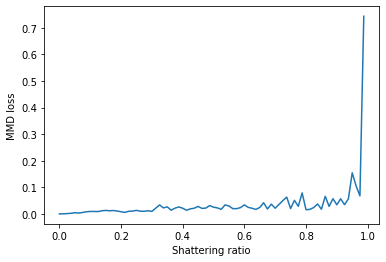

In [6]:
plt.plot(shattering_ratio, torch.Tensor(mmd_scores))
plt.xlabel('Shattering ratio')
plt.ylabel('MMD loss')
plt.show()

In [7]:
for i in range(len(mmd_scores)):
    mmd_scores[i].backward()

In [34]:
grad = []
for i in range(len(X)):
    grad.append(X[i].grad)

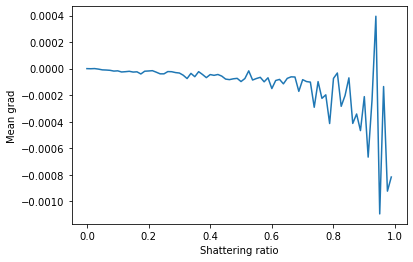

In [27]:
plt.plot(shattering_ratio, grad)
plt.xlabel('Shattering ratio')
plt.ylabel('Mean grad')
plt.show()

In [88]:
positive_value = []
for i in range(len(grad)):
    positive_value.append((grad[i]>0).sum().item() / (grad[i]!=0).sum().item())
positive_value

[0.4,
 0.375,
 0.55,
 0.45,
 0.48,
 0.43333333333333335,
 0.29285714285714287,
 0.45625,
 0.2777777777777778,
 0.275,
 0.31363636363636366,
 0.43333333333333335,
 0.3423076923076923,
 0.21071428571428572,
 0.48,
 0.428125,
 0.15588235294117647,
 0.2388888888888889,
 0.25,
 0.37,
 0.11666666666666667,
 0.4318181818181818,
 0.34782608695652173,
 0.41458333333333336,
 0.224,
 0.3923076923076923,
 0.40370370370370373,
 0.3875,
 0.19137931034482758,
 0.37,
 0.17903225806451614,
 0.2125,
 0.3712121212121212,
 0.16176470588235295,
 0.29285714285714287,
 0.2986111111111111,
 0.35,
 0.40789473684210525,
 0.26794871794871794,
 0.14375,
 0.35365853658536583,
 0.21071428571428572,
 0.1755813953488372,
 0.28863636363636364,
 0.3244444444444444,
 0.3010869565217391,
 0.20425531914893616,
 0.36666666666666664,
 0.24081632653061225,
 0.338,
 0.40098039215686276,
 0.2932692307692308,
 0.33867924528301885,
 0.26944444444444443,
 0.2872727272727273,
 0.24285714285714285,
 0.32719298245614037,
 0.31120689

In [31]:
x = Variable(torch.Tensor(data_1[7]), requires_grad=True)
y = Variable(torch.Tensor(data_2[7]))

In [32]:
out = mmd_rbf(x, y)

In [33]:
out.backward()

In [36]:
x.grad.shape

torch.Size([800, 2])